<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/ml-apps/rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning

## Orso's live

Make our bear Orso find all the honey in his home turf choosing the most convenient path.  

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/images/Orso.png?raw=1'>
<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/images/turf.png?raw=1'>

https://opendatascience.com/bears-need-to-learn-as-well-practical-reinforcement-learning-with-tensorflow-2-0-tf-agents

## Installation and Setup

In [1]:
#@title
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 9)
# mpl.rcParams["figure.dpi"] = 300

import sys
if 'google.colab' in sys.modules:
    !pip install -q easyagents 2>/dev/null
    !pip install -q networkx==2.3.0 2>/dev/null

import easyagents
import tensorflow as tf
import tensorflow_probability as tfp
import tf_agents


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


## Orso's Environment (OpenAI Gym)

In [0]:
#@title
import gym
from gym.utils import seeding
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13,
        'P': 14,
        'Q': 15,
        'R': 16,
        'T': 17,
        'U': 18,
        'V': 19,
        'W': 20,
        'X': 21,
        'Y': 22,
        'Z': 23
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O',
        14: 'P',
        15: 'Q',
        16: 'R',
        17: 'T',
        18: 'U',
        19: 'V',
        20: 'W',
        21: 'X',
        22: 'Y',
        23: 'Z'
    }
    return state_map[state_as_int]

cost_lake = 300
cost_mountain = 200
cost_woods = 100
cost_meddow = 50

graph = {
            'S': [('A', cost_lake), ('B', cost_woods), ('M', cost_mountain), ('Z', cost_meddow)],
            'A': [('S', cost_lake), ('B', cost_woods), ('E', cost_mountain), ('D', cost_woods)],
            'B': [('S', cost_woods), ('A', cost_woods), ('K', cost_mountain)],
            'C': [('M', cost_woods), ('L', cost_mountain), ('H', cost_mountain)],
            'D': [('A', cost_woods), ('F', cost_lake), ('Z', cost_mountain)],
            'E': [('A', cost_mountain), ('H', cost_woods), ('F', cost_lake)],
            'F': [('D', cost_lake), ('G', cost_mountain), ('E', cost_lake)],
            'G': [('F', cost_mountain), ('O', cost_mountain)],
            'H': [('E', cost_woods), ('K', cost_lake), ('C', cost_mountain)],
            'K': [('B', cost_mountain), ('H', cost_lake), ('L', cost_woods)],
            'L': [('C', cost_mountain), ('M', cost_meddow), ('K', cost_woods), ('O', cost_woods)],
            'M': [('S', cost_mountain), ('C', cost_woods), ('L', cost_meddow), ('N', cost_lake)],
            'N': [('M', cost_lake), ('O', cost_mountain), ('Z', cost_mountain)],
            'O': [('N', cost_mountain), ('G', cost_mountain), ('L', cost_woods)],
            'N': [('M', cost_woods), ('O', cost_woods), ('Z', cost_woods)],
            'O': [('N', cost_woods), ('G', cost_mountain), ('Z', cost_lake)],
            'Z': [('O', cost_lake), ('N', cost_mountain), ('S', cost_meddow), ('Z', cost_mountain)]
        }

class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self, reset_rewards=True):
        self.honey_reward = 1000
        # self.illegal_action_penalty = 0
        self.illegal_action_penalty = -1000
        # self.completion_reward = 2000
        self.completion_reward = 5000
        # self.completion_reward = 0
        self.honey_quota = 2
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        # need to set rewards on initial call
        self.reset_rewards = True
        self.reset()
        self.reset_rewards = reset_rewards

        self.optimum = self.calculate_customers_reward() 

        base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/jupyter_notebooks/images/"
        self.image_orso = mpi.imread(base + "Orso.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        source = self.state

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        # it just toggled from not done to done
        if done and not self.isDone:
            self.envEpisodeCount += 1
            self.customerReward += self.completion_reward

        self.reward = (self.customerReward - self.cost) / self.optimum

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": source, "to": destination, "cost": self.cost, "reward": self.customerReward}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def get_rest_rewards(self):
        all_rest_rewards = list(self.customer_reward.values())
        return all_rest_rewards

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = self.illegal_action_penalty

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == self.completion_reward

    def calculate_customers_reward(self):
        sum = self.completion_reward

        for value in self.customer_reward.values():
            sum += value
        return sum

    # each node gets a reward, either 0 or reward for honey
    def modulate_reward(self):

        # rewards are only at a few random places
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / self.honey_quota)

        # starting from 1, not 0, so that 'S' (position of the cave) never gets a reward 
        self.samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)

        self.fill_pots()

    def fill_pots(self):
        self._honeypot_places = []
        self.customer_reward = {}

        node_names = list(self.map.keys())
        # initialize all nodes with 0
        for node_name in node_names:
            self.customer_reward[node_name] = 0
        for sample in self.samples:
            self.customer_reward[node_names[sample]] = self.honey_reward
            self._honeypot_places = self._honeypot_places + [node_names[sample]]


    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.reward = 0
        self.envEpisodeCount += 1
        if self.reset_rewards:
          self.modulate_reward()
        else:
          self.fill_pots()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for action, (target, cost) in enumerate(connections):
                if cost >= cost_lake:
                    color = 'dodgerblue'
                elif cost >= cost_mountain:
                    color = 'darkgoldenrod'
                elif cost >= cost_woods:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                directed_label = str(source) + ":" + str(action)
                existing_edge = nx_graph.get_edge_data(source, target)
                if existing_edge is not None: 
                    directed_label = str(existing_edge['label']) + ' - ' + directed_label
                nx_graph.add_edge(source, target, color=color, weight=6, cost=cost, label=directed_label, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self, 
                          render_graph_labels=False, 
                          render_costs=False, 
                          render_node_names=False,
                          render_honey=True):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure()
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]

        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edges=edges, edge_color=edge_colors, width=edge_weights, with_labels=render_graph_labels or render_node_names)

        if render_graph_labels:
          edge_labels = [self.nx_graph[u][v]['label'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_labels))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        if render_costs:
          edge_costs = [self.nx_graph[u][v]['cost'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_costs))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        if render_honey:
          for n in self.nx_pos:
              node = self.nx_graph.node[n]
              image = node['image']
              if image is not None: 
                  xp, yp = self.nx_pos[n]
                  offset_image = OffsetImage(image, node['zoom'])
                  offset_image.image.axes = ax
                  ab = AnnotationBbox(offset_image, (xp, yp),
                                      xybox=(0, 0),
                                      xycoords='data',
                                      boxcoords="offset points",
                                      pad=0.0,
                                      frameon=False
                                      )
                  ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human', render_graph_labels=False, render_costs=False, render_node_names=False, render_honey=True):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure(render_graph_labels=render_graph_labels, 
                                   render_costs=render_costs, 
                                   render_node_names=render_node_names,
                                   render_honey=render_honey)
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

# Perfect Solutions using Best-First Search

* finds the best solution
* bit exponential complexity

In [134]:
env = OrsoEnv(reset_rewards=False)
env.reset()

array([   0., -300.,  900., -200.,  -50.,    0.,    0., 1000.,    0.,
       1000., 1000., 1000.,    0.,    0., 1000., 1000.,    0.,    0.,
       1000.,    0.])

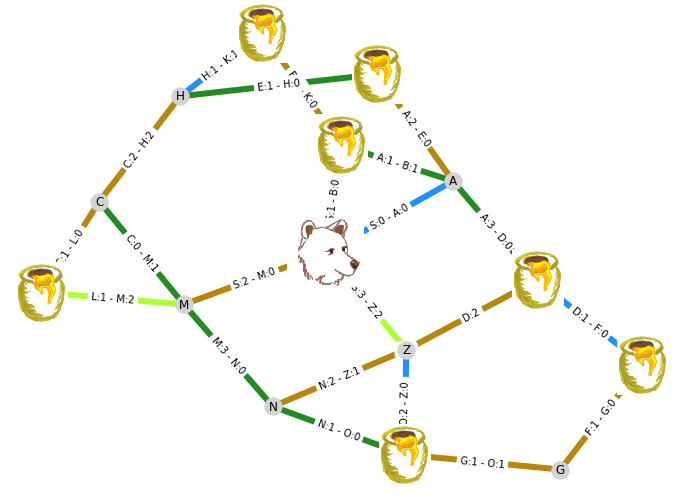

In [135]:
env.render(render_graph_labels=True)

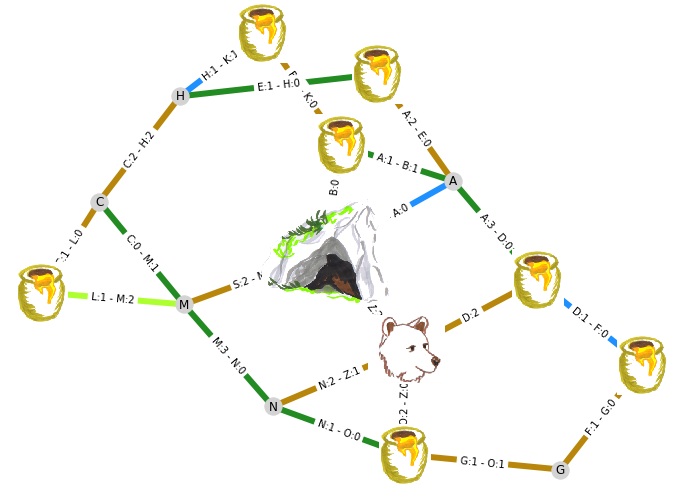

(array([  23.,  700., -200.,  -50., -200.,    0.,    0., 1000.,    0.,
        1000., 1000., 1000.,    0.,    0., 1000., 1000.,    0.,    0.,
        1000.,    0.]),
 -0.004166666666666667,
 False,
 {'cost': 50, 'from': 'S', 'reward': 0, 'to': 'Z'})

In [136]:
env.reset()
observation = env.step(3)
env.render(render_graph_labels=True)
observation

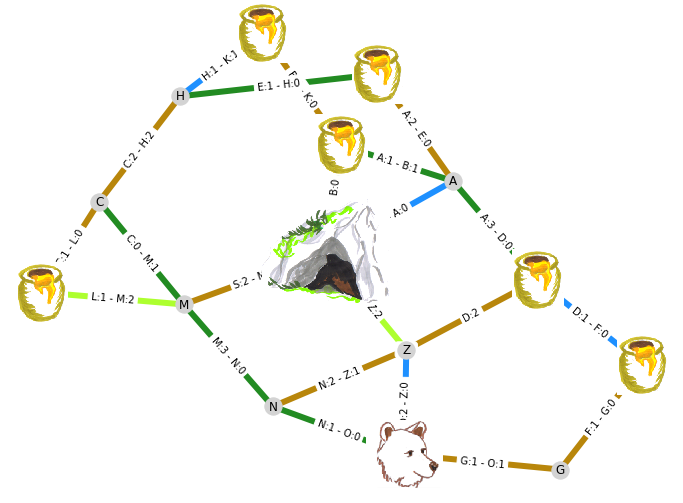

(array([   13.,  -100.,  -200.,  -300., -1000.,     0.,     0.,  1000.,
            0.,  1000.,  1000.,  1000.,     0.,     0.,  1000.,  1000.,
            0.,     0.,     0.,     0.]),
 0.058333333333333334,
 False,
 {'cost': 300, 'from': 'Z', 'reward': 1000, 'to': 'O'})

In [137]:
observation = env.step(0)
env.render(render_graph_labels=True)
observation

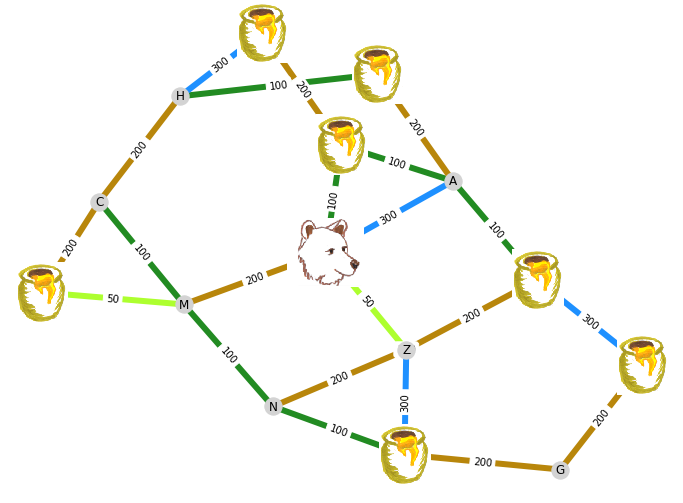

In [138]:
env.reset()
env.render(render_costs=True, render_node_names=True)

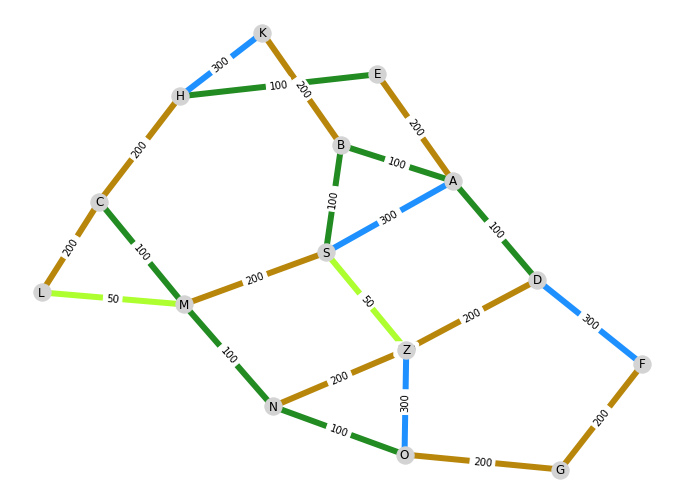

In [139]:
env.reset()
env.render(render_costs=True, render_node_names=True, render_honey=False)

In [0]:
# from https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/berater-v12.ipynb

from copy import deepcopy
import json

class Baseline():

  def __init__(self, env, verbose=0):
    self.env = env
    self.verbose = verbose
    self.reset()

  def reset(self):
    self.map = self.env.map
    self.rewards = self.env.customer_reward.copy()
    
  def as_string(self, state):
    # reward/cost does not hurt, but is useless, path obsucres same state
    new_state = {
        'rewards': state['rewards'],
        'position': state['position']
    }
    return json.dumps(new_state, sort_keys=True)
  
  def is_goal(self, state):
    if state['position'] != 'S': return False
    for reward in state['rewards'].values():
      if reward != 0: return False
    return True
    

  def expand(self, state):
    states = []
    for position, cost in self.map[state['position']]:
      new_state = deepcopy(state)
      new_state['position'] = position
      new_state['rewards'][position] = 0
      reward = state['rewards'][position]
      new_state['reward'] += reward
      new_state['cost'] += cost
      new_state['path'].append(position)
      states.append(new_state)
    return states

  def search(self, root, max_depth = 25):
      closed = set()
      open = [root]

      while open:
          state = open.pop(0)
          if self.as_string(state) in closed: continue  

          closed.add(self.as_string(state))

          depth = len(state['path'])
          if depth > max_depth:
            if self.verbose > 0:
              print("Visited:", len(closed))
              print("Reached max depth, without reaching goal")
            return None

          if self.is_goal(state):
            scaled_reward = (state['reward'] - state['cost'] + self.env.completion_reward) / self.env.optimum
            state['scaled_reward'] = scaled_reward
            if self.verbose > 0:
              print("Scaled reward:", scaled_reward)            
              print("Perfect path", state['path'])
            return state

          expanded = self.expand(state)
          open += expanded
          # make this best first
          open.sort(key=lambda state: state['cost'])
        
  def find_optimum(self):
    initial_state = {
        'rewards': self.rewards.copy(),
        'position': 'S',
        'reward': 0,
        'cost': 0,
        'path': ['S']
    }
    return self.search(initial_state)
  
  def benchmark(self, model, sample_runs=100):
    self.verbose = 0
    BeraterEnv.showStep = False
    BeraterEnv.showDone = False

    perfect_rewards = []
    model_rewards = []
    for run in range(sample_runs):
      observation = self.env.reset()
      self.reset()
      
      optimum_state = self.find_optimum()
      perfect_rewards.append(optimum_state['scaled_reward'])
      
      state = np.zeros((1, 2*128))
      dones = np.zeros((1))

      for t in range(1000):
        actions, _, state, _ = model.step(observation, S=state, M=dones)
        observation, reward, done, info = self.env.step(actions[0])
        if done:
          break
      model_rewards.append(env.totalReward)
    return perfect_rewards, model_rewards
  
  def score(self, model, sample_runs=100):
    perfect_rewards, model_rewards = self.benchmark(model, sample_runs=100)
    
    perfect_score_mean, perfect_score_std = np.array(perfect_rewards).mean(), np.array(perfect_rewards).std()
    test_score_mean, test_score_std = np.array(model_rewards).mean(), np.array(model_rewards).std()
    
    return perfect_score_mean, perfect_score_std, test_score_mean, test_score_std

In [141]:
env.reset()

baseline = Baseline(env)
perfect_solution = baseline.find_optimum()
cost = perfect_solution['cost']
reward_scored = perfect_solution['reward']
scaled_reward = perfect_solution['scaled_reward']
path = perfect_solution['path']
complete_reward = env.optimum
cost, complete_reward, scaled_reward, len(path), path

(2200,
 12000,
 0.8166666666666667,
 15,
 ['S', 'B', 'K', 'H', 'E', 'A', 'D', 'F', 'G', 'O', 'N', 'M', 'L', 'M', 'S'])

# Train policy with tfagents PpoAgent


In [93]:
!nvidia-smi

Wed Mar 25 13:38:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

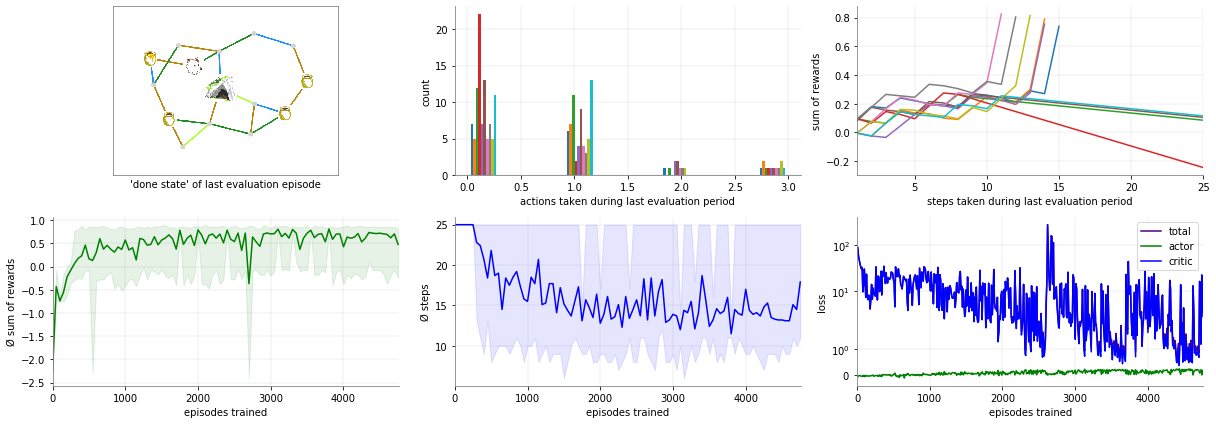

KeyboardInterrupt: ignored

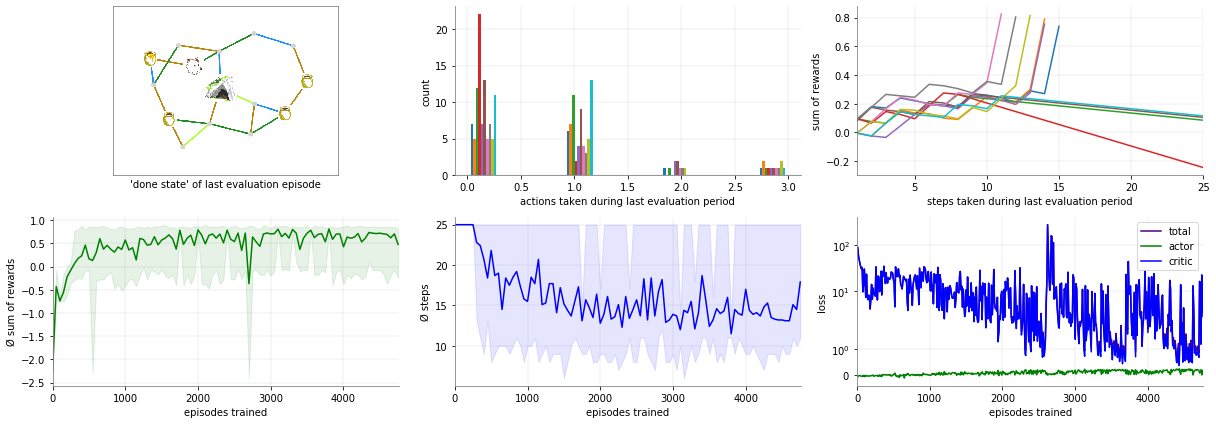

In [97]:
%%time

from easyagents.env import register_with_gym
from easyagents.callbacks import plot
from easyagents.agents import PpoAgent
      
env_name="Orso-v1"
register_with_gym(gym_env_name=env_name, entry_point=OrsoEnv, max_episode_steps=1000)
ppo_agent = PpoAgent(gym_env_name=env_name, fc_layers=(500,500,500))

plots = [plot.State(), 
         plot.Actions(), 
         plot.StepRewards(), 
         plot.Rewards(), 
         plot.Steps(), 
         plot.Loss(),
         plot.ToMovie()]
ppo_agent.train(plots, 
                # learning_rate=1e-4,
                # num_iterations = 600, 
                learning_rate=5e-5,
                num_iterations = 500, 
                num_episodes_per_iteration = 10,
                max_steps_per_episode = 25)

In [80]:
metrics = ppo_agent.evaluate(num_episodes=10)
metrics.rewards.min, metrics.rewards.mean, metrics.rewards.max, metrics.steps.min, metrics.steps.mean, metrics.steps.max

(-0.3666666666666667, 0.6933333333333334, 0.8611111111111112, 8, 14.5, 50)

## Play a random episode - see the bear cruise his turf (turn ouput into a movie)

In [11]:
ppo_agent.play([plot.State(), plot.ToMovie(fps=3)], num_episodes=1, max_steps_per_episode=20)

# Now let the bear solve the initial task

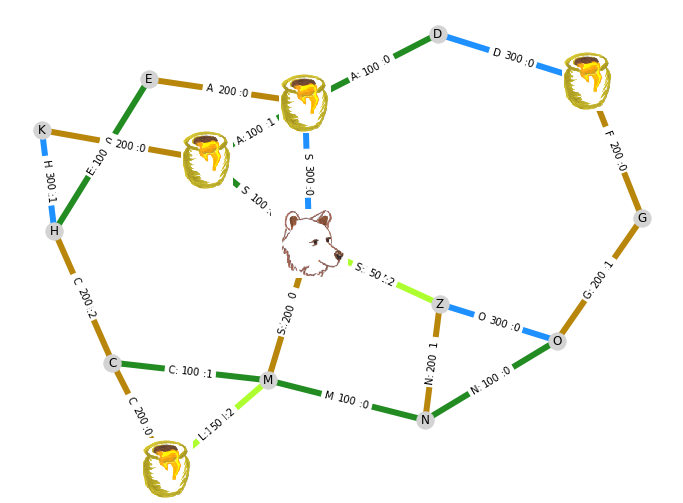

In [12]:
env.reset()
env.render(render_costs=True, render_node_names=True, render_graph_labels=True)

## All we need to play is the greedy tf-agents policy

* now we longer abstract from the backend
* technically the policy is a TensorFlow network
* this is what we would need to bring into production

In [13]:
tf_ppo_agent = ppo_agent._backend_agent
policy = tf_ppo_agent._trained_policy
policy.name

'greedy_policy'

## tf-agents need a different kind of environment, but we can wrap the original one

In [0]:
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment

wrapped_env = suite_gym.wrap_env(env)
eval_env = tf_py_environment.TFPyEnvironment(wrapped_env)

## The agent will not perform as well as the perfect solution

at least not in all cases, otherwise we have proven P = NP

In [15]:
time_step = eval_env.reset()

cost = 0
steps = 0
max_steps = 25

while not time_step.is_last() and steps < max_steps:
  # print(time_step.observation.numpy())
  action_step = policy.action(time_step)
  cost += env.cost
  print(action_step.action.numpy()[0])  
  time_step = eval_env.step(action_step.action)
  steps += 1

print(cost)

1
1
3
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
2800


In [16]:
import base64
import imageio
import IPython

time_step = eval_env.reset()

num_episodes = 1

steps = 0
max_steps = 25

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=5) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(wrapped_env.render())
    while not time_step.is_last() and steps < max_steps:
      action_step = policy.action(time_step)
#       print(action_step.action.numpy()[0])  
      time_step = eval_env.step(action_step.action)
      video.append_data(wrapped_env.render())
      steps += 1


embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (864, 648) to (864, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
